# Exploratory Data Analysis and Clustering Songs from Spotify API

Spotify holds the place as the most popular streaming music platform in the world. Users can listen to an extensive variety of songs of many genres using a computer, tablet, or smartphone connected to the Internet. In this project, Spotipy, the Python library for the Spotify API was utilized to retrieve song data from five different genres: hip hop, rock, jazz, pop, and classical. The data was then analyzed and unsupervised learning clustering models were created to group together songs into various genres. These were compared with both silhoutte scores and visualizations.

1. Import Libraries
2. Spotify API to Retrieve Data
3. Exploratory Data Analysis and Visualizations
4. Clustering Models
    1. KMeans
    2. DBSCAN
    3. Mean Shift

### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import seaborn as sns
import plotly.express as px

import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer
from yellowbrick.target import FeatureCorrelation

from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import MeanShift

from itertools import product
import pickle as pkl
import warnings
warnings.filterwarnings('ignore')

### Spotify API - Data Retrieval

In [2]:
SPOTIFY_CLIENT_ID = pkl.load(open('client_id.pkl', 'rb'))
SPOTIFY_CLIENT_SECRET = pkl.load(open('client_secret.pkl', 'rb'))

In [3]:
sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(
    client_id=SPOTIFY_CLIENT_ID, client_secret=SPOTIFY_CLIENT_SECRET))

In [4]:
'''

def get_all_playlist_tracks(username, playlist_id):
    results = sp.user_playlist_tracks(username, playlist_id)
    tracks = results['items']
    while results['next']:
        results = sp.next(results)
        tracks.extend(results['items'])
    return tracks

# Example usage
username = 'your_username'
playlist_id = 'your_playlist_id'
all_tracks = get_all_playlist_tracks(username, playlist_id)

# Now 'all_tracks' contains all the tracks from the specified playlist
'''

"\n\ndef get_all_playlist_tracks(username, playlist_id):\n    results = sp.user_playlist_tracks(username, playlist_id)\n    tracks = results['items']\n    while results['next']:\n        results = sp.next(results)\n        tracks.extend(results['items'])\n    return tracks\n\n# Example usage\nusername = 'your_username'\nplaylist_id = 'your_playlist_id'\nall_tracks = get_all_playlist_tracks(username, playlist_id)\n\n# Now 'all_tracks' contains all the tracks from the specified playlist\n"

In [4]:
# fetch hip hop tracks

d = []
total = 1  # Temporary variable
offset = 0
genre = 'hip hop'  # Replace with the desired genre
year = '2023'   # Replace with the desired year
query = f'genre:{genre} AND year:{year}'

while offset < total:
    results = sp.search(q=query, type='track', market='US', offset=offset, limit=50)
    total = results['tracks']['total']
    offset += 50  # Increase the offset

    for idx, track in enumerate(results['tracks']['items']):
        track_id = track['id']
        audio_features = sp.audio_features(track_id)[0]
        d.append({
            'Track': track['name'],
            'Album': track['album']['name'],
            'Artist': track['artists'][0]['name'],
            'Genre': 'hip hop',
            'Popularity': track['popularity'],
            'Explicit': track['explicit'],
            'Duration': track['duration_ms'],
            'Danceability': audio_features['danceability'], 
            'Energy': audio_features['energy'], 
            'Key': audio_features['key'], 
            'Loudness': audio_features['loudness'], 
            'Mode': audio_features['mode'], 
            'Speechiness': audio_features['speechiness'], 
            'Acousticness': audio_features['acousticness'], 
            'Instrumentalness': audio_features['instrumentalness'], 
            'Liveness': audio_features['liveness'], 
            'Valence': audio_features['valence'], 
            'Tempo': audio_features['tempo']
        })

df_hiphop = pd.DataFrame(d)


In [5]:
pkl.dump(df_hiphop, open('df_hiphop.pkl', 'wb'))

In [6]:
df_hiphop = pkl.load(open('df_hiphop.pkl', 'rb'))

In [7]:
df_hiphop.sample(5)

Track  \
83                                   More Than U Know   
1   Say Less (feat. Lil Durk & A Boogie Wit da Hoo...   
30                                   Free Killa & R.o   
45                Planet Rock - Vocal & Bonus Beats 1   
9                                            In A Box   

                                                Album            Artist  \
83  ...And You Don't Stop - A Celebration of 50 Ye...       Prince Paul   
1                                  Hip Hop 50: Vol. 2       Swizz Beatz   
30                                 I Hope Y'all Ready               Nuk   
45  ...And You Don't Stop - A Celebration of 50 Ye...  Afrika Bambaataa   
9                                 Hoppa and Friends 3          DJ Hoppa   

      Genre  Popularity  Explicit  Duration  Danceability  Energy  Key  \
83  hip hop           4      True    264504         0.833   0.741    4   
1   hip hop          38      True    174853         0.523   0.830    4   
30  hip hop           6      True    160844         0.748   0.666    1   
45  hip hop           8     False    451883         0.946   0.836    6   
9   hip hop          21      True    162666         0.608   0.617    5   

    Loudness  Mode  Speechiness  Acousticness  Instrumentalness  Liveness  \
83    -5.291     0        0.146       0.00766          0.000000     0.357   
1     -4.659     0        0.209       0.03900          0.000000     0.212   
30    -6.742     0        0.249       0.05180          0.000000     0.110   
45    -5.844     0        0.150       0.08200          0.000028     0.129   
9     -5.011     0        0.334       0.13900          0.000000     0.404   

    Valence    Tempo  
83    0.408  104.046  
1     0.527  170.085  
30    0.441   89.923  
45    0.768  126.944  
9     0.429   89.728

In [8]:
df_hiphop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Track             100 non-null    object 
 1   Album             100 non-null    object 
 2   Artist            100 non-null    object 
 3   Genre             100 non-null    object 
 4   Popularity        100 non-null    int64  
 5   Explicit          100 non-null    bool   
 6   Duration          100 non-null    int64  
 7   Danceability      100 non-null    float64
 8   Energy            100 non-null    float64
 9   Key               100 non-null    int64  
 10  Loudness          100 non-null    float64
 11  Mode              100 non-null    int64  
 12  Speechiness       100 non-null    float64
 13  Acousticness      100 non-null    float64
 14  Instrumentalness  100 non-null    float64
 15  Liveness          100 non-null    float64
 16  Valence           100 non-null    float64
 17

In [9]:
df_hiphop['Track'].nunique()

95

In [107]:
df_hiphop = df_hiphop.drop_duplicates(subset=['Track'])

In [10]:
# fetch rock tracks

d = []
total = 1  # Temporary variable
offset = 0
genre = 'rock'  # Replace with the desired genre
year = '2023'   # Replace with the desired year
query = f'genre:{genre} AND year:{year}'

while offset < total:
    results = sp.search(q=query, type='track', market='US', offset=offset, limit=50)
    total = results['tracks']['total']
    offset += 50  # Increase the offset

    for idx, track in enumerate(results['tracks']['items']):
        track_id = track['id']
        audio_features = sp.audio_features(track_id)[0]
        d.append({
            'Track': track['name'],
            'Album': track['album']['name'],
            'Artist': track['artists'][0]['name'],
            'Genre': 'rock',
            'Popularity': track['popularity'],
            'Explicit': track['explicit'],
            'Duration': track['duration_ms'],
            'Danceability': audio_features['danceability'], 
            'Energy': audio_features['energy'], 
            'Key': audio_features['key'], 
            'Loudness': audio_features['loudness'], 
            'Mode': audio_features['mode'], 
            'Speechiness': audio_features['speechiness'], 
            'Acousticness': audio_features['acousticness'], 
            'Instrumentalness': audio_features['instrumentalness'], 
            'Liveness': audio_features['liveness'], 
            'Valence': audio_features['valence'], 
            'Tempo': audio_features['tempo']
        })

df_rock = pd.DataFrame(d)


In [11]:
pkl.dump(df_rock, open('df_rock.pkl', 'wb'))

In [12]:
df_rock = pkl.load(open('df_rock.pkl', 'rb'))

In [13]:
df_rock.sample(5)

Track  \
95                                 Me & Me   
67                       Southern and Slow   
68  The Ballad Of John And Yoko - 2015 Mix   
25                        Let Me Down Easy   
94                                    Burn   

                                         Album                      Artist  \
95                                     Me & Me                 The Beaches   
67  Play It Again: The Songs You Loved In 2023                  Luke Bryan   
68      The Beatles 1967 – 1970 (2023 Edition)                 The Beatles   
25                                      AURORA       Daisy Jones & The Six   
94                                        Burn  Josiah and the Bonnevilles   

   Genre  Popularity  Explicit  Duration  Danceability  Energy  Key  Loudness  \
95  rock          41      True    147596         0.547   0.907    7    -3.544   
67  rock          41     False    187493         0.504   0.772    6    -5.865   
68  rock          52     False    180786         0.651   0.871    4    -7.421   
25  rock          61     False    204215         0.620   0.904    9    -4.221   
94  rock          43     False    130501         0.639   0.464    9    -4.818   

    Mode  Speechiness  Acousticness  Instrumentalness  Liveness  Valence  \
95     1       0.1260       0.02600          0.000000    0.2220    0.692   
67     0       0.0558       0.03570          0.000022    0.0775    0.496   
68     1       0.0322       0.00578          0.000006    0.1110    0.964   
25     0       0.2080       0.00257          0.000006    0.1840    0.732   
94     1       0.0281       0.57400          0.000000    0.2300    0.263   

      Tempo  
95   85.029  
67  152.013  
68  135.338  
25  136.936  
94  140.745

In [14]:
df_rock.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Track             100 non-null    object 
 1   Album             100 non-null    object 
 2   Artist            100 non-null    object 
 3   Genre             100 non-null    object 
 4   Popularity        100 non-null    int64  
 5   Explicit          100 non-null    bool   
 6   Duration          100 non-null    int64  
 7   Danceability      100 non-null    float64
 8   Energy            100 non-null    float64
 9   Key               100 non-null    int64  
 10  Loudness          100 non-null    float64
 11  Mode              100 non-null    int64  
 12  Speechiness       100 non-null    float64
 13  Acousticness      100 non-null    float64
 14  Instrumentalness  100 non-null    float64
 15  Liveness          100 non-null    float64
 16  Valence           100 non-null    float64
 17

In [15]:
df_rock['Track'].nunique()

91

In [108]:
df_rock = df_rock.drop_duplicates(subset=['Track'])

In [16]:
# fetch jazz tracks

d = []
total = 1  # Temporary variable
offset = 0
genre = 'jazz'  # Replace with the desired genre
year = '2023'   # Replace with the desired year
query = f'genre:{genre} AND year:{year}'

while offset < total:
    results = sp.search(q=query, type='track', market='US', offset=offset, limit=50)
    total = results['tracks']['total']
    offset += 50  # Increase the offset

    for idx, track in enumerate(results['tracks']['items']):
        track_id = track['id']
        audio_features = sp.audio_features(track_id)[0]
        d.append({
            'Track': track['name'],
            'Album': track['album']['name'],
            'Artist': track['artists'][0]['name'],
            'Genre': 'jazz',
            'Popularity': track['popularity'],
            'Explicit': track['explicit'],
            'Duration': track['duration_ms'],
            'Danceability': audio_features['danceability'], 
            'Energy': audio_features['energy'], 
            'Key': audio_features['key'], 
            'Loudness': audio_features['loudness'], 
            'Mode': audio_features['mode'], 
            'Speechiness': audio_features['speechiness'], 
            'Acousticness': audio_features['acousticness'], 
            'Instrumentalness': audio_features['instrumentalness'], 
            'Liveness': audio_features['liveness'], 
            'Valence': audio_features['valence'], 
            'Tempo': audio_features['tempo']
        })

df_jazz = pd.DataFrame(d)


In [18]:
pkl.dump(df_jazz, open('df_jazz.pkl', 'wb'))

In [19]:
df_jazz = pkl.load(open('df_jazz.pkl', 'rb'))

In [20]:
df_jazz.sample(5)

Track                         Album             Artist  \
93           Bright Sky                    Bright Sky  Birds Of The West   
31  Love Vibe and Learn  Noflik - Love Vibe and Learn             Noflik   
28             Continuo                   Ease Vol. 2   Wieland & Ulrich   
64          Remembrance                   Remembrance        Ben & Katsy   
29            Butterfly             World Music Radio        Jon Batiste   

   Genre  Popularity  Explicit  Duration  Danceability  Energy  Key  Loudness  \
93  jazz          38     False    165974         0.669  0.3210   11   -14.684   
31  jazz          39     False    132187         0.554  0.0782    1   -11.843   
28  jazz          47     False    167125         0.730  0.4840   11    -8.756   
64  jazz          40     False    247874         0.454  0.1140    8   -18.728   
29  jazz          53     False    230440         0.463  0.1740    5   -12.371   

    Mode  Speechiness  Acousticness  Instrumentalness  Liveness  Valence  \
93     0       0.0630         0.786           0.92300    0.1110    0.360   
31     1       0.4630         0.846           0.91900    0.1040    0.340   
28     0       0.4010         0.695           0.06190    0.0659    0.614   
64     1       0.0410         0.847           0.71700    0.3720    0.148   
29     1       0.0322         0.974           0.00355    0.0962    0.122   

      Tempo  
93  153.994  
31  239.670  
28   83.099  
64   84.854  
29  139.787

In [21]:
df_jazz.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Track             100 non-null    object 
 1   Album             100 non-null    object 
 2   Artist            100 non-null    object 
 3   Genre             100 non-null    object 
 4   Popularity        100 non-null    int64  
 5   Explicit          100 non-null    bool   
 6   Duration          100 non-null    int64  
 7   Danceability      100 non-null    float64
 8   Energy            100 non-null    float64
 9   Key               100 non-null    int64  
 10  Loudness          100 non-null    float64
 11  Mode              100 non-null    int64  
 12  Speechiness       100 non-null    float64
 13  Acousticness      100 non-null    float64
 14  Instrumentalness  100 non-null    float64
 15  Liveness          100 non-null    float64
 16  Valence           100 non-null    float64
 17

In [22]:
df_jazz['Track'].nunique()

97

In [109]:
df_jazz = df_jazz.drop_duplicates(subset=['Track'])

In [23]:
# fetch pop tracks

d = []
total = 1  # Temporary variable
offset = 0
genre = 'pop'  # Replace with the desired genre
year = '2023'   # Replace with the desired year
query = f'genre:{genre} AND year:{year}'

while offset < total:
    results = sp.search(q=query, type='track', market='US', offset=offset, limit=50)
    total = results['tracks']['total']
    offset += 50  # Increase the offset

    for idx, track in enumerate(results['tracks']['items']):
        track_id = track['id']
        audio_features = sp.audio_features(track_id)[0]
        d.append({
            'Track': track['name'],
            'Album': track['album']['name'],
            'Artist': track['artists'][0]['name'],
            'Genre': 'pop',
            'Popularity': track['popularity'],
            'Explicit': track['explicit'],
            'Duration': track['duration_ms'],
            'Danceability': audio_features['danceability'], 
            'Energy': audio_features['energy'], 
            'Key': audio_features['key'], 
            'Loudness': audio_features['loudness'], 
            'Mode': audio_features['mode'], 
            'Speechiness': audio_features['speechiness'], 
            'Acousticness': audio_features['acousticness'], 
            'Instrumentalness': audio_features['instrumentalness'], 
            'Liveness': audio_features['liveness'], 
            'Valence': audio_features['valence'], 
            'Tempo': audio_features['tempo']
        })

df_pop = pd.DataFrame(d)


In [24]:
pkl.dump(df_pop, open('df_pop.pkl', 'wb'))

In [25]:
df_pop = pkl.load(open('df_pop.pkl', 'rb'))

In [26]:
df_pop.sample(5)

Track  \
24                                                ETA   
61  Givin’ Up (Not The One) (Don Toliver & 21 Sava...   
19                                         HOT TO GO!   
29          Heartbroken (feat. Jessie Murph & Polo G)   
35                          red (feat. Morgan Wallen)   

                                                Album         Artist Genre  \
24                           NewJeans 2nd EP 'Get Up'       NewJeans   pop   
61  METRO BOOMIN PRESENTS SPIDER-MAN: ACROSS THE S...    Don Toliver   pop   
19            The Rise and Fall of a Midwest Princess  Chappell Roan   pop   
29  Diplo Presents Thomas Wesley: Chapter 2 - Swam...          Diplo   pop   
35                         the mockingbird & THE CROW          HARDY   pop   

    Popularity  Explicit  Duration  Danceability  Energy  Key  Loudness  Mode  \
24          81     False    151373         0.812   0.749   10    -6.389     0   
61          68     False    234693         0.714   0.586    2    -6.925     1   
19          78     False    184841         0.741   0.761    6    -4.921     1   
29          72     False    204325         0.670   0.589    2    -5.693     1   
35          72     False    205767         0.582   0.878   11    -4.564     1   

    Speechiness  Acousticness  Instrumentalness  Liveness  Valence    Tempo  
24       0.0397        0.1080               0.0    0.0599    0.841  134.971  
61       0.0604        0.0211               0.0    0.1730    0.283  108.983  
19       0.0397        0.0179               0.0    0.2740    0.961  140.039  
29       0.0873        0.3790               0.0    0.0942    0.628  146.978  
35       0.0404        0.0305               0.0    0.0791    0.581  140.030

In [27]:
df_pop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Track             100 non-null    object 
 1   Album             100 non-null    object 
 2   Artist            100 non-null    object 
 3   Genre             100 non-null    object 
 4   Popularity        100 non-null    int64  
 5   Explicit          100 non-null    bool   
 6   Duration          100 non-null    int64  
 7   Danceability      100 non-null    float64
 8   Energy            100 non-null    float64
 9   Key               100 non-null    int64  
 10  Loudness          100 non-null    float64
 11  Mode              100 non-null    int64  
 12  Speechiness       100 non-null    float64
 13  Acousticness      100 non-null    float64
 14  Instrumentalness  100 non-null    float64
 15  Liveness          100 non-null    float64
 16  Valence           100 non-null    float64
 17

In [28]:
df_pop['Track'].nunique()

93

In [110]:
df_pop = df_pop.drop_duplicates(subset=['Track'])

In [29]:
# fetch classical tracks

d = []
total = 1  # Temporary variable
offset = 0
genre = 'classical'  # Replace with the desired genre
year = '2023'   # Replace with the desired year
query = f'genre:{genre} AND year:{year}'

while offset < total:
    results = sp.search(q=query, type='track', market='US', offset=offset, limit=50)
    total = results['tracks']['total']
    offset += 50  # Increase the offset

    for idx, track in enumerate(results['tracks']['items']):
        track_id = track['id']
        audio_features = sp.audio_features(track_id)[0]
        d.append({
            'Track': track['name'],
            'Album': track['album']['name'],
            'Artist': track['artists'][0]['name'],
            'Genre': 'classical',
            'Popularity': track['popularity'],
            'Explicit': track['explicit'],
            'Duration': track['duration_ms'],
            'Danceability': audio_features['danceability'], 
            'Energy': audio_features['energy'], 
            'Key': audio_features['key'], 
            'Loudness': audio_features['loudness'], 
            'Mode': audio_features['mode'], 
            'Speechiness': audio_features['speechiness'], 
            'Acousticness': audio_features['acousticness'], 
            'Instrumentalness': audio_features['instrumentalness'], 
            'Liveness': audio_features['liveness'], 
            'Valence': audio_features['valence'], 
            'Tempo': audio_features['tempo']
        })

df_classical = pd.DataFrame(d)


In [30]:
pkl.dump(df_classical, open('df_classical.pkl', 'wb'))

In [31]:
df_classical = pkl.load(open('df_classical.pkl', 'rb'))

In [32]:
df_classical.sample(5)

Track  \
0        Pachelbel: Canon and Gigue in D Major: Canon   
33  Concerto grosso in G Minor, Op. 6 No. 8, "Chri...   
32                  Where Life Comes from and Returns   
24  Debussy: 2 Arabesques, CD 74, L. 66: No. 1, An...   
1                                      There and Then   

                                       Album             Artist      Genre  \
0                Pachelbel: Canon in D Major   Johann Pachelbel  classical   
33                  Música Clásica Para Leer  Arcangelo Corelli  classical   
32                                   SEASONS     Akira Kosemura  classical   
24  Morning Piano - Debussy: Arabesque No. 1     Claude Debussy  classical   
1                        I Will Keep Sailing        Piotr Wiese  classical   

    Popularity  Explicit  Duration  Danceability  Energy  Key  Loudness  Mode  \
0           64     False    300613         0.123  0.1500    2   -16.647     1   
33          40     False    115600         0.167  0.0569    3   -24.655     1   
32          38     False    235647         0.479  0.0829    2   -21.026     1   
24          43     False    293381         0.247  0.0168    4   -30.321     1   
1           49     False    144000         0.373  0.0760    1   -23.331     1   

    Speechiness  Acousticness  Instrumentalness  Liveness  Valence    Tempo  
0        0.0350         0.714             0.913    0.1030   0.0904   84.183  
33       0.0449         0.912             0.952    0.1150   0.0851  111.459  
32       0.0385         0.977             0.933    0.0694   0.0636  103.692  
24       0.0371         0.994             0.922    0.0906   0.0592   66.823  
1        0.0307         0.972             0.894    0.1090   0.3810   96.962

In [33]:
df_classical.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Track             100 non-null    object 
 1   Album             100 non-null    object 
 2   Artist            100 non-null    object 
 3   Genre             100 non-null    object 
 4   Popularity        100 non-null    int64  
 5   Explicit          100 non-null    bool   
 6   Duration          100 non-null    int64  
 7   Danceability      100 non-null    float64
 8   Energy            100 non-null    float64
 9   Key               100 non-null    int64  
 10  Loudness          100 non-null    float64
 11  Mode              100 non-null    int64  
 12  Speechiness       100 non-null    float64
 13  Acousticness      100 non-null    float64
 14  Instrumentalness  100 non-null    float64
 15  Liveness          100 non-null    float64
 16  Valence           100 non-null    float64
 17

In [34]:
df_classical['Track'].nunique()

100

In [111]:
df_classical = df_classical.drop_duplicates(subset=['Track'])

In [112]:
df = pd.concat([df_hiphop, df_rock, df_jazz, df_pop, df_classical], axis=0)
df.reset_index(inplace=True, drop=True)

In [160]:
df.sample(5)

Track  \
58   Looking for the Perfect Beat - Vocal   
420                       Canzoni stonate   
245               Wine and Jazz - BGM Mix   
339       Happiness (feat. Asake & Gunna)   
320       Two Tens (feat. Anderson .Paak)   

                                                 Album  \
58   ...And You Don't Stop - A Celebration of 50 Ye...   
420                   My Love Songs (Expanded Edition)   
245   Morning Jazz Cafe - Relaxing Smooth Coffee Music   
339                    Happiness (feat. Asake & Gunna)   
320                    Two Tens (feat. Anderson .Paak)   

                                 Artist      Genre  Popularity  Explicit  \
58                     Afrika Bambaataa    hip hop           7     False   
420                      Andrea Bocelli  classical          36     False   
245  Restaurant Lounge Background Music       jazz          40     False   
339                                Sarz        pop          74     False   
320                              Cordae        pop          65      True   

     Duration  Danceability  Energy  Key  Loudness  Mode  Speechiness  \
58     422138         0.846  0.9960    9    -3.045     0       0.0688   
420    324590         0.541  0.4730    0   -10.353     0       0.0467   
245    130104         0.549  0.0922    0   -15.700     1       0.0356   
339    174743         0.804  0.7440   10    -5.390     0       0.0395   
320    152371         0.603  0.5460    4    -7.525     0       0.3500   

     Acousticness  Instrumentalness  Liveness  Valence    Tempo  
58          0.329          0.001120    0.0925    0.633  118.727  
420         0.800          0.018800    0.3370    0.434   77.611  
245         0.966          0.823000    0.1080    0.255   94.311  
339         0.184          0.388000    0.1040    0.775  104.981  
320         0.194          0.000003    0.0783    0.667   87.990

In [161]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 476 entries, 0 to 475
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Track             476 non-null    object 
 1   Album             476 non-null    object 
 2   Artist            476 non-null    object 
 3   Genre             476 non-null    object 
 4   Popularity        476 non-null    int64  
 5   Explicit          476 non-null    bool   
 6   Duration          476 non-null    int64  
 7   Danceability      476 non-null    float64
 8   Energy            476 non-null    float64
 9   Key               476 non-null    int64  
 10  Loudness          476 non-null    float64
 11  Mode              476 non-null    int32  
 12  Speechiness       476 non-null    float64
 13  Acousticness      476 non-null    float64
 14  Instrumentalness  476 non-null    float64
 15  Liveness          476 non-null    float64
 16  Valence           476 non-null    float64
 1

In [115]:
df['Track'].nunique()

475

In [116]:
df.isnull().any()

Track               False
Album               False
Artist              False
Genre               False
Popularity          False
Explicit            False
Duration            False
Danceability        False
Energy              False
Key                 False
Loudness            False
Mode                False
Speechiness         False
Acousticness        False
Instrumentalness    False
Liveness            False
Valence             False
Tempo               False
dtype: bool

### EDA and Visualizations

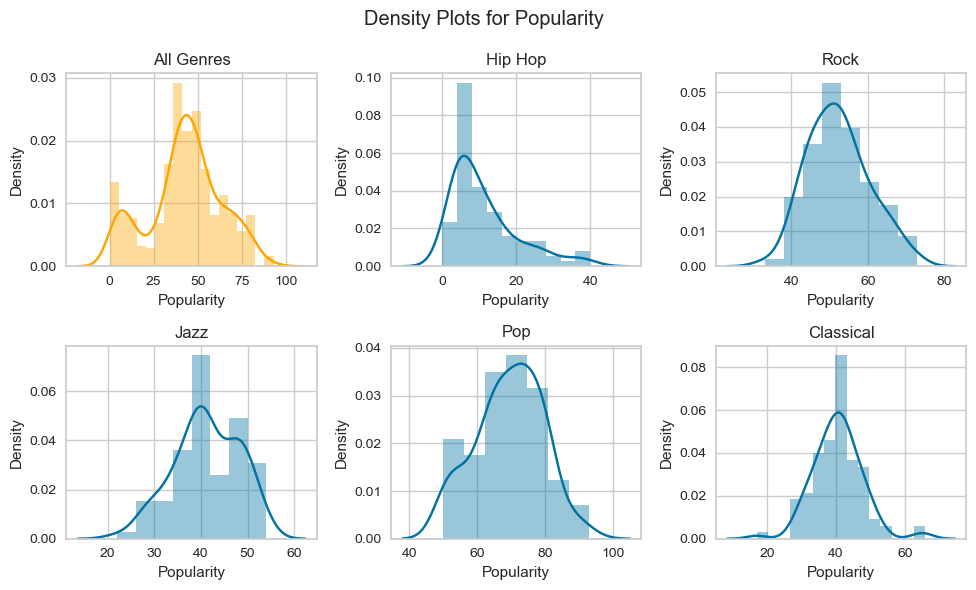

In [159]:
fig, axes = plt.subplots(2, 3)

sns.distplot(df['Popularity'], kde=True, color='orange', ax=axes[0,0]).set(title='All Genres')
sns.distplot(df_hiphop['Popularity'], kde=True, ax=axes[0,1]).set(title='Hip Hop')
sns.distplot(df_rock['Popularity'], kde=True, ax=axes[0,2]).set(title='Rock')
sns.distplot(df_jazz['Popularity'], kde=True, ax=axes[1,0]).set(title='Jazz')
sns.distplot(df_pop['Popularity'], kde=True, ax=axes[1,1]).set(title='Pop')
sns.distplot(df_classical['Popularity'], kde=True, ax=axes[1,2]).set(title='Classical')

plt.suptitle('Density Plots for Popularity')
plt.tight_layout()
plt.savefig('density plots.png')
plt.show()

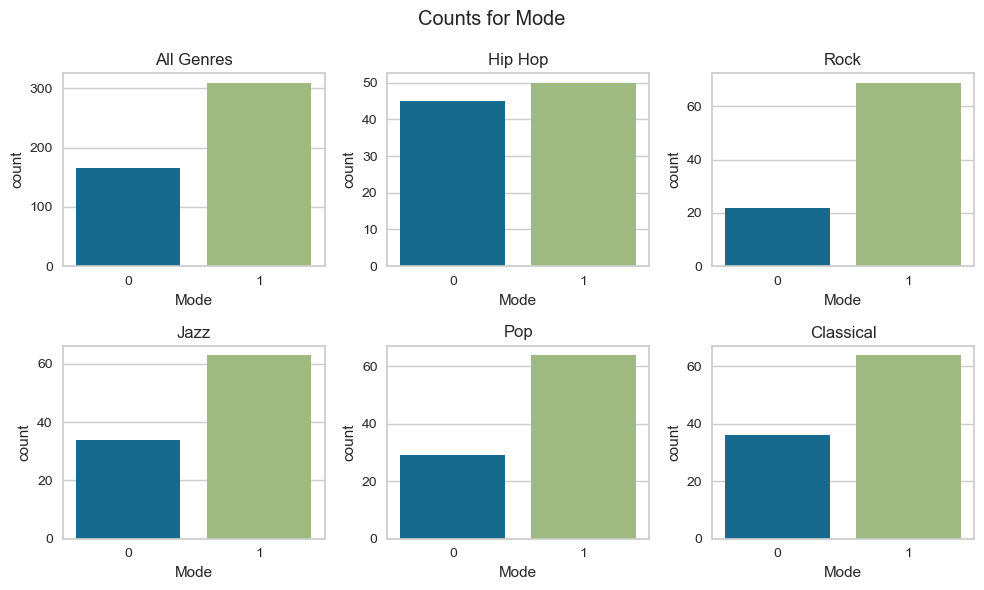

In [158]:
fig, axes = plt.subplots(2, 3)
sns.countplot(x='Mode', data=df, ax=axes[0,0]).set(title='All Genres')
sns.countplot(x='Mode', data=df_hiphop, ax=axes[0,1]).set(title='Hip Hop')
sns.countplot(x='Mode', data=df_rock, ax=axes[0,2]).set(title='Rock')
sns.countplot(x='Mode', data=df_jazz, ax=axes[1,0]).set(title='Jazz')
sns.countplot(x='Mode', data=df_pop, ax=axes[1,1]).set(title='Pop')
sns.countplot(x='Mode', data=df_classical, ax=axes[1,2]).set(title='Classical')

plt.suptitle('Counts for Mode')
plt.tight_layout()
plt.savefig('mode count plots.png')
plt.show()

In [50]:
feature_names = df.drop('Popularity', axis=1).columns
numeric_feature_names = df[feature_names].select_dtypes(np.number).columns

<AxesSubplot:title={'center':'Features Correlation with Popularity for All Genres'}, xlabel='Pearson Correlation'>

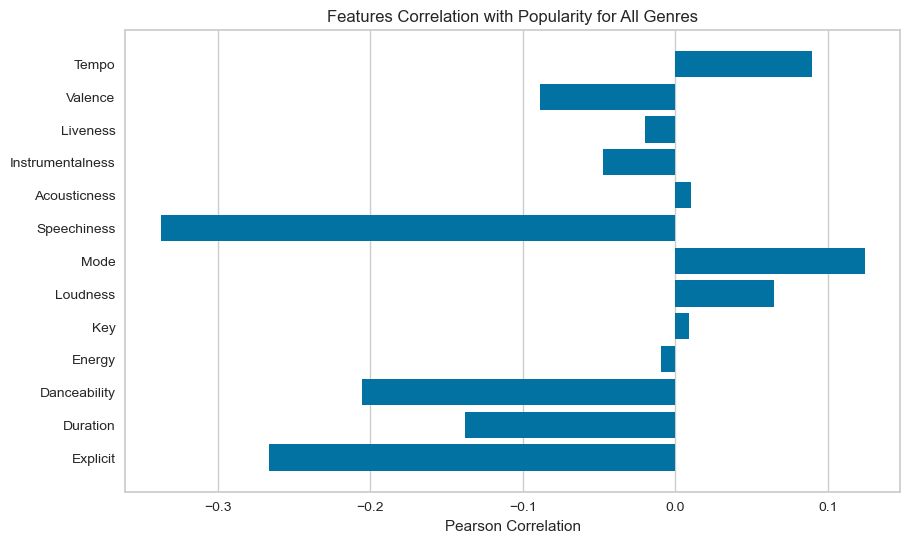

In [122]:
X, y = df[numeric_feature_names], df['Popularity']
features = np.array(numeric_feature_names)
visualizer = FeatureCorrelation(labels=features, colors='yellowbrick', title='Features Correlation with Popularity for All Genres')

plt.rcParams['figure.figsize'] = (10,6)
visualizer.fit(X, y)
visualizer.show(outpath='popularity corr all genres.png')

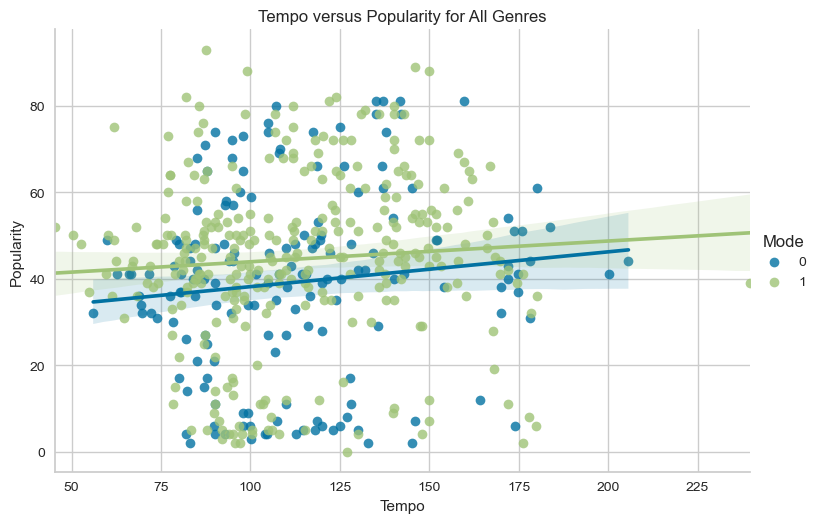

In [121]:
sns.lmplot('Tempo', 'Popularity', data=df, hue='Mode', aspect=1.5)
plt.title('Tempo versus Popularity for All Genres')
plt.savefig('lmplot tempo vs popularity all genres.png')
plt.show()

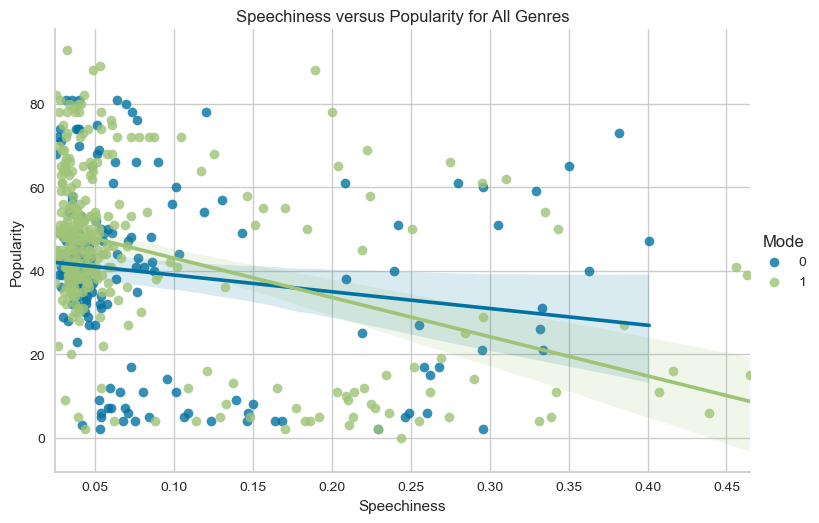

In [124]:
sns.lmplot('Speechiness', 'Popularity', data=df, hue='Mode', aspect=1.5)
plt.title('Speechiness versus Popularity for All Genres')
plt.savefig('lmplot speechiness vs popularity all genres.png')
plt.show()

<AxesSubplot:title={'center':'Features Correlation with Popularity for Hip Hop'}, xlabel='Pearson Correlation'>

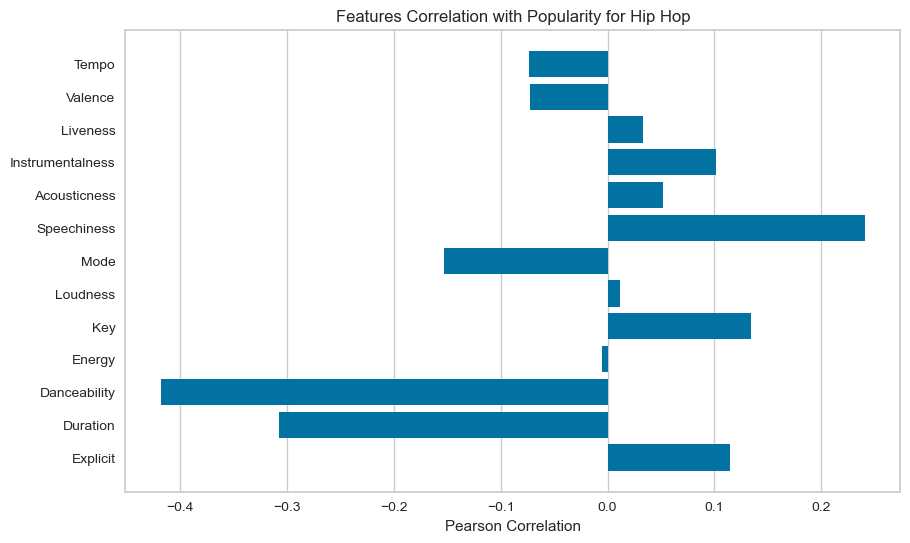

In [118]:
X, y = df_hiphop[numeric_feature_names], df_hiphop['Popularity']
features = np.array(numeric_feature_names)
visualizer = FeatureCorrelation(labels=features, colors='yellowbrick', title='Features Correlation with Popularity for Hip Hop')

plt.rcParams['figure.figsize'] = (10,6)
visualizer.fit(X, y)
visualizer.show(outpath='popularity corr hip hop.png')

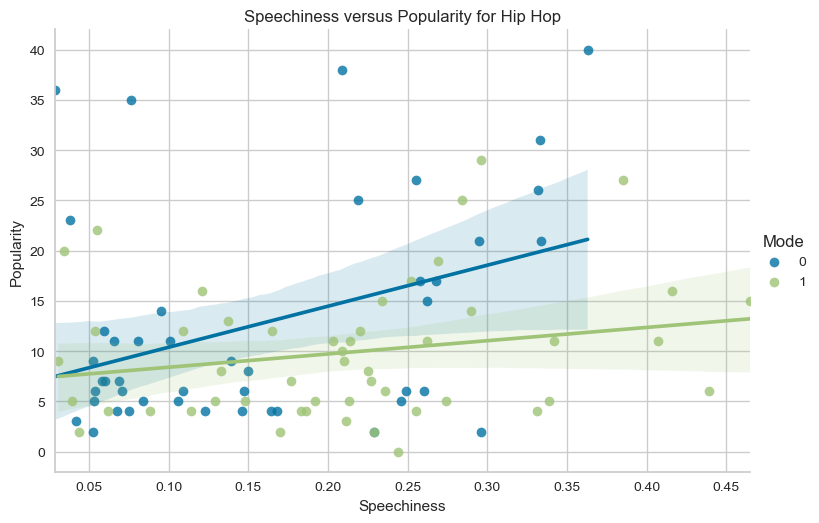

In [131]:
sns.lmplot('Speechiness', 'Popularity', data=df_hiphop, hue='Mode', aspect=1.5)
plt.title('Speechiness versus Popularity for Hip Hop')
plt.savefig('lmplot speechiness vs popularity hip hop.png')
plt.show()

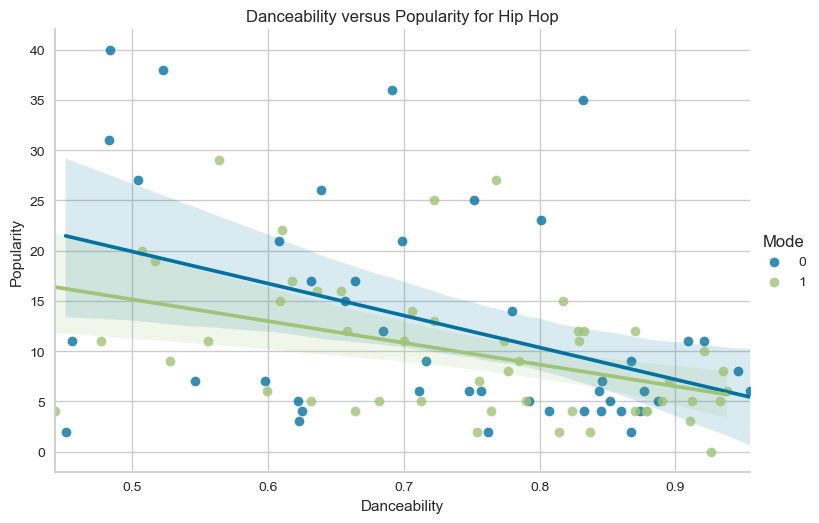

In [133]:
sns.lmplot('Danceability', 'Popularity', data=df_hiphop, hue='Mode', aspect=1.5)
plt.title('Danceability versus Popularity for Hip Hop')
plt.savefig('lmplot tempo vs popularity hip hop.png')
plt.show()

<AxesSubplot:title={'center':'Features Correlation with Popularity for Rock'}, xlabel='Pearson Correlation'>

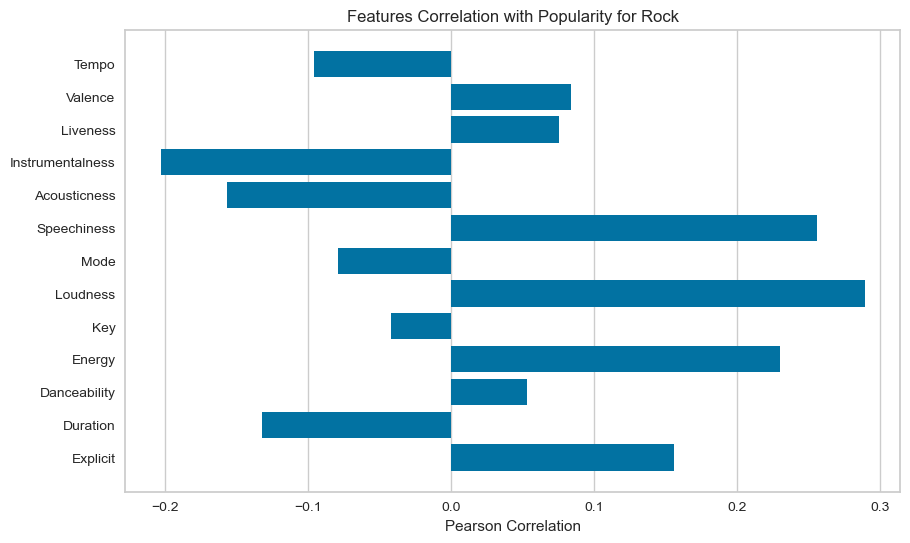

In [120]:
X, y = df_rock[numeric_feature_names], df_rock['Popularity']
features = np.array(numeric_feature_names)
visualizer = FeatureCorrelation(labels=features, colors='yellowbrick', title='Features Correlation with Popularity for Rock')

plt.rcParams['figure.figsize'] = (10,6)
visualizer.fit(X, y)
visualizer.show(outpath='popularity corr rock.png')

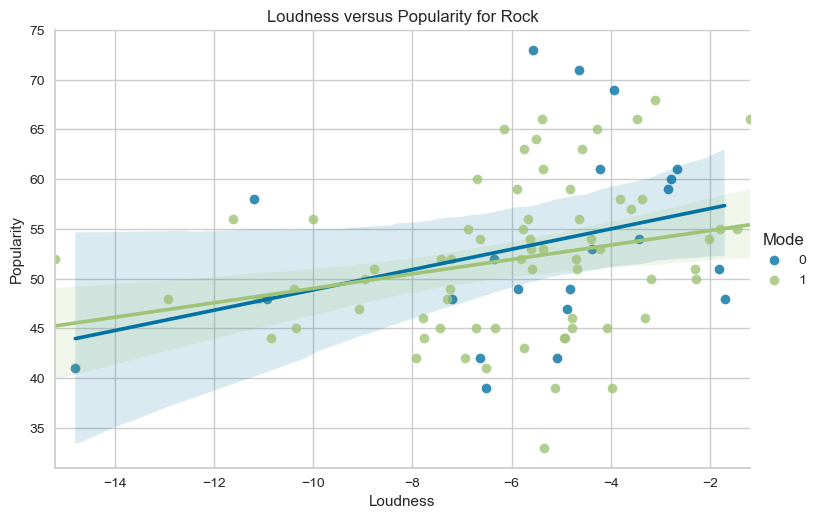

In [134]:
sns.lmplot('Loudness', 'Popularity', data=df_rock, hue='Mode', aspect=1.5)
plt.title('Loudness versus Popularity for Rock')
plt.savefig('lmplot loudness vs popularity rock.png')
plt.show()

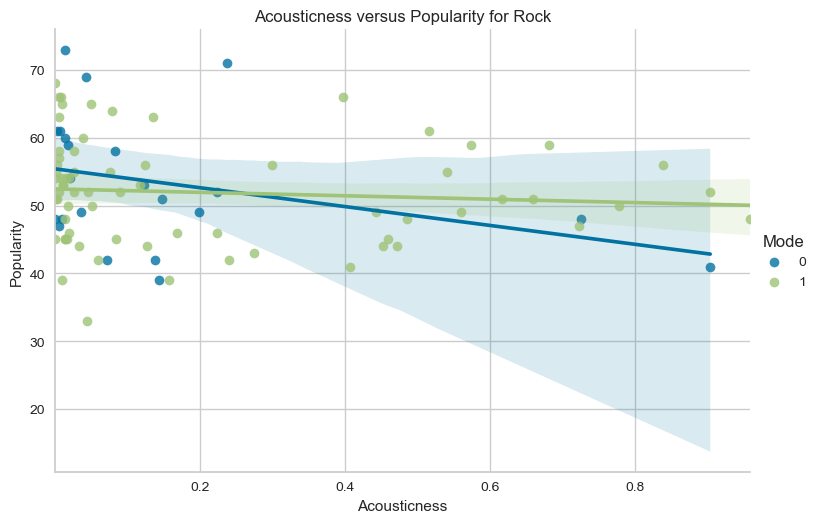

In [144]:
sns.lmplot('Acousticness', 'Popularity', data=df_rock, hue='Mode', aspect=1.5)
plt.title('Acousticness versus Popularity for Rock')
plt.savefig('lmplot acousticness vs popularity rock.png')
plt.show()

<AxesSubplot:title={'center':'Features Correlation with Popularity for Jazz'}, xlabel='Pearson Correlation'>

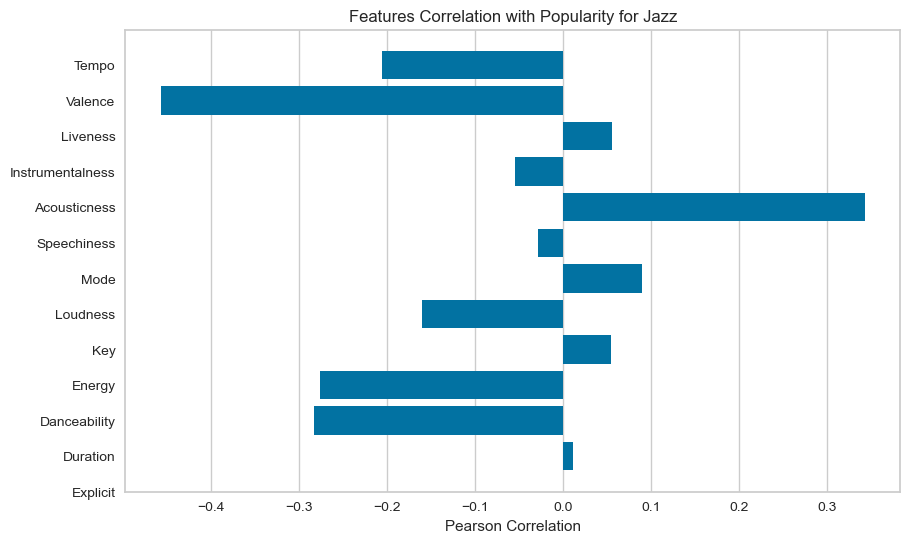

In [126]:
X, y = df_jazz[numeric_feature_names], df_jazz['Popularity']
features = np.array(numeric_feature_names)
visualizer = FeatureCorrelation(labels=features, colors='yellowbrick', title='Features Correlation with Popularity for Jazz')

plt.rcParams['figure.figsize'] = (10,6)
visualizer.fit(X, y)
visualizer.show(outpath='popularity corr jazz.png')

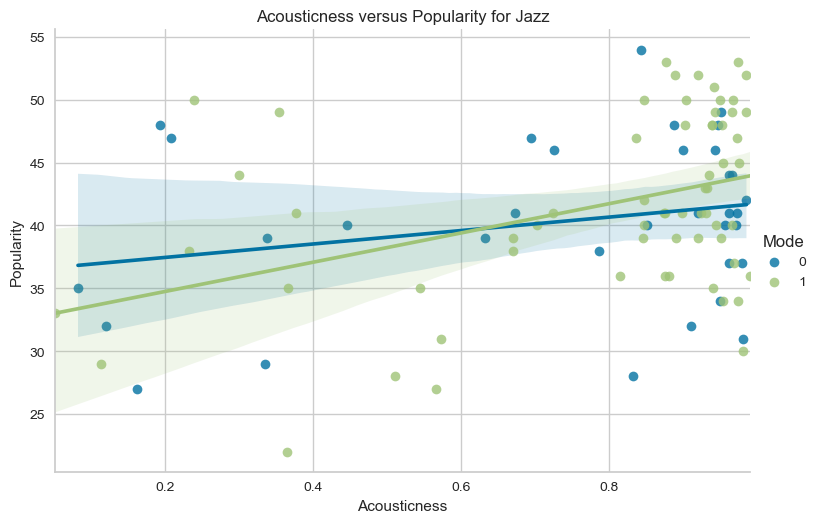

In [136]:
sns.lmplot('Acousticness', 'Popularity', data=df_jazz, hue='Mode', aspect=1.5)
plt.title('Acousticness versus Popularity for Jazz')
plt.savefig('lmplot acousticness vs popularity jazz.png')
plt.show()

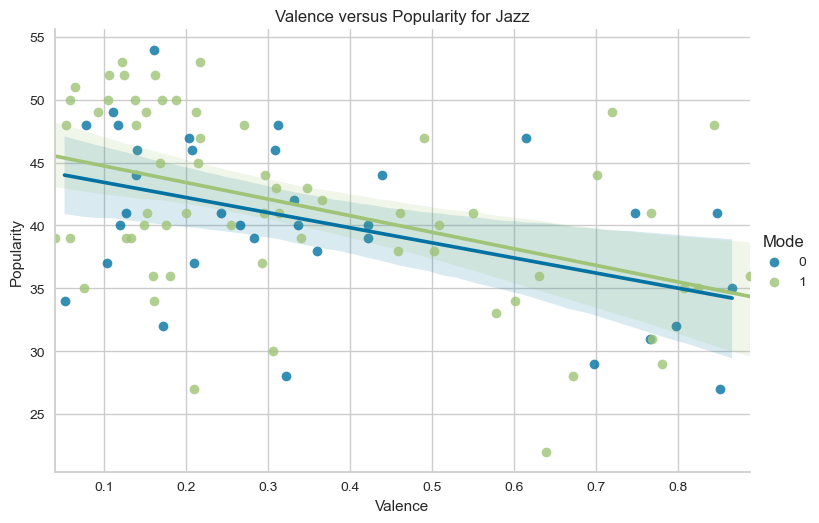

In [137]:
sns.lmplot('Valence', 'Popularity', data=df_jazz, hue='Mode', aspect=1.5)
plt.title('Valence versus Popularity for Jazz')
plt.savefig('lmplot valence vs popularity jazz.png')
plt.show()

<AxesSubplot:title={'center':'Features Correlation with Popularity for Pop'}, xlabel='Pearson Correlation'>

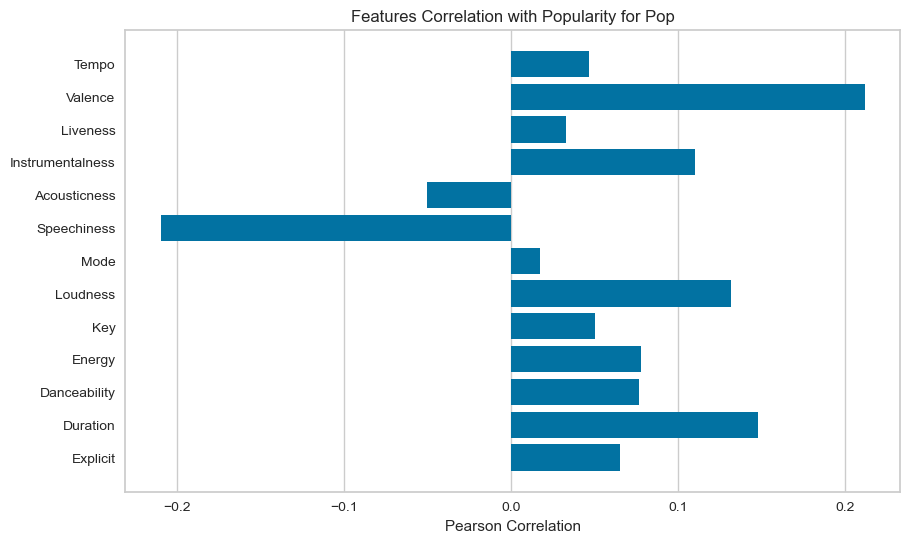

In [127]:
X, y = df_pop[numeric_feature_names], df_pop['Popularity']
features = np.array(numeric_feature_names)
visualizer = FeatureCorrelation(labels=features, colors='yellowbrick', title='Features Correlation with Popularity for Pop')

plt.rcParams['figure.figsize'] = (10,6)
visualizer.fit(X, y)
visualizer.show(outpath='popularity corr pop.png')

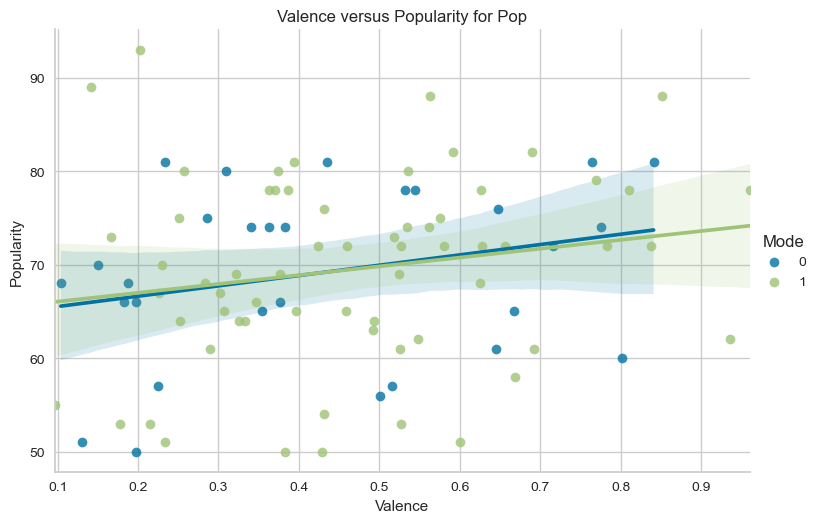

In [138]:
sns.lmplot('Valence', 'Popularity', data=df_pop, hue='Mode', aspect=1.5)
plt.title('Valence versus Popularity for Pop')
plt.savefig('lmplot valence vs popularity pop.png')
plt.show()

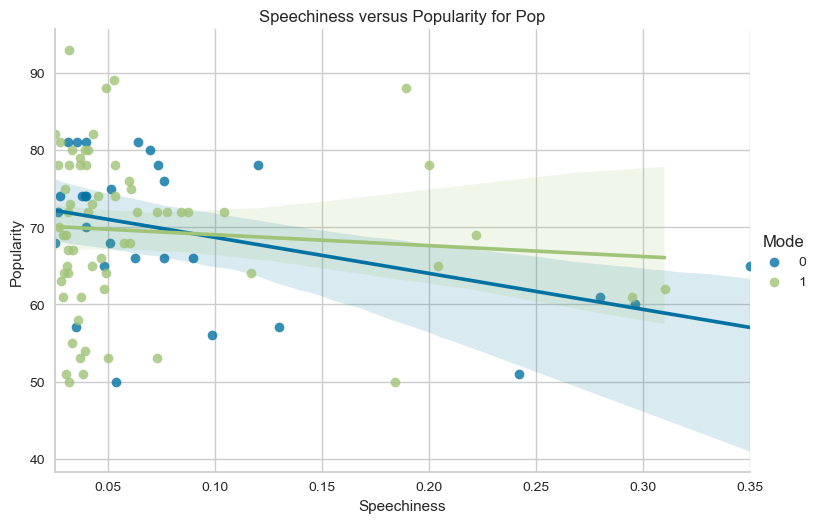

In [139]:
sns.lmplot('Speechiness', 'Popularity', data=df_pop, hue='Mode', aspect=1.5)
plt.title('Speechiness versus Popularity for Pop')
plt.savefig('lmplot speechiness vs popularity pop.png')
plt.show()

<AxesSubplot:title={'center':'Features Correlation with Popularity for Classical'}, xlabel='Pearson Correlation'>

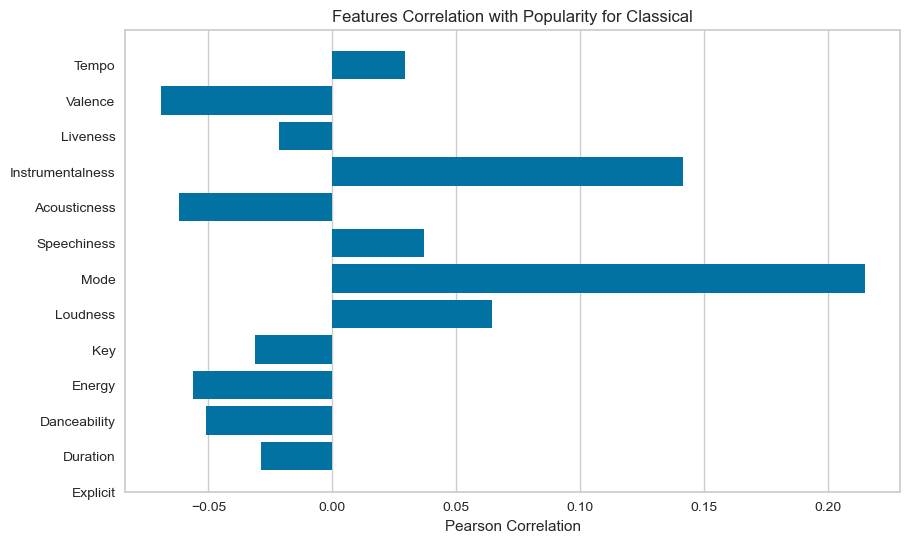

In [128]:
X, y = df_classical[numeric_feature_names], df_classical['Popularity']
features = np.array(numeric_feature_names)
visualizer = FeatureCorrelation(labels=features, colors='yellowbrick', title='Features Correlation with Popularity for Classical')

plt.rcParams['figure.figsize'] = (10,6)
visualizer.fit(X, y)
visualizer.show(outpath='popularity corr classical.png')

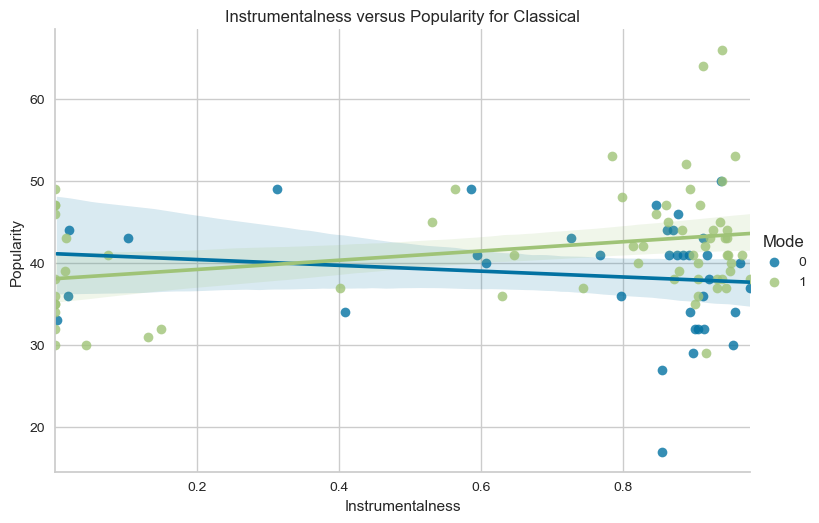

In [141]:
sns.lmplot('Instrumentalness', 'Popularity', data=df_classical, hue='Mode', aspect=1.5)
plt.title('Instrumentalness versus Popularity for Classical')
plt.savefig('lmplot instrumentalness vs popularity classical.png')
plt.show()

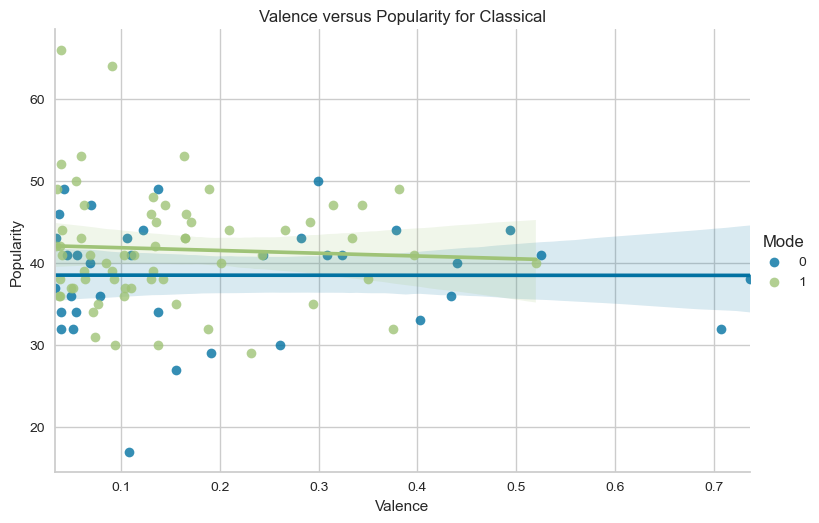

In [142]:
sns.lmplot('Valence', 'Popularity', data=df_classical, hue='Mode', aspect=1.5)
plt.title('Valence versus Popularity for Classical')
plt.savefig('lmplot valence vs popularity classical.png')
plt.show()

### Clustering Models

In [77]:
X = df[numeric_feature_names]
mm = MinMaxScaler()
X = mm.fit_transform(X)

In [65]:
X[0]

array([1.00000000e+00, 1.47517456e-01, 4.64224775e-01, 7.05409210e-01,
       1.00000000e+00, 8.55536787e-01, 0.00000000e+00, 7.68550034e-01,
       4.80869488e-01, 1.75689479e-06, 2.34252779e-01, 3.44931271e-01,
       2.14372083e-01])

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

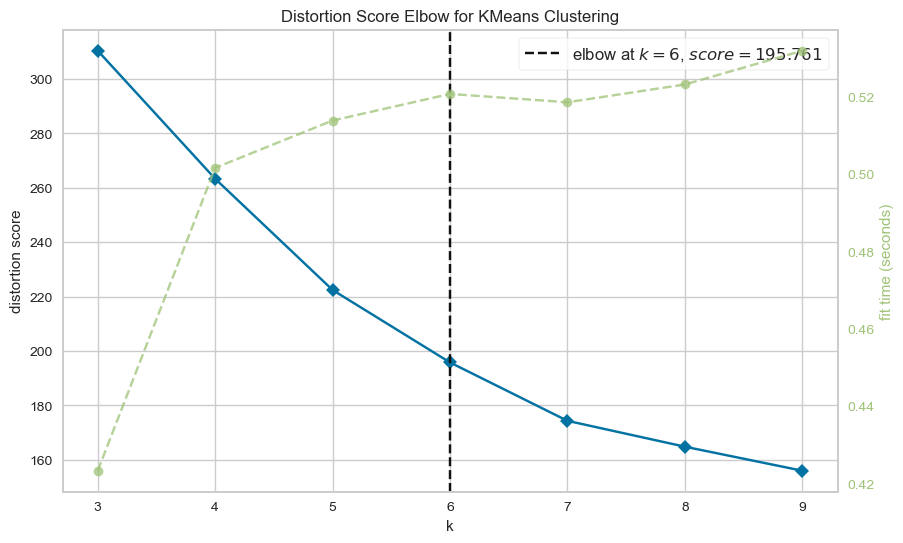

In [74]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(3,10), colors='yellowbrick')
visualizer.fit(X)
visualizer.show(outpath='K Elbow.png')

In [78]:
kmeans = KMeans(n_clusters=6)
kmeans.fit(X)
df['cluster kmeans'] = kmeans.predict(X)

In [79]:
pkl.dump(kmeans, open('kmeans.pkl', 'wb'))

In [80]:
kmeans = pkl.load(open('kmeans.pkl', 'rb'))

In [82]:
s_score_kmeans = silhouette_score(X, df['cluster kmeans'])
print('silhouette score for KMeans: {}'.format(s_score_kmeans))

silhouette score for KMeans: 0.33350638967683044


<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 475 Samples in 6 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

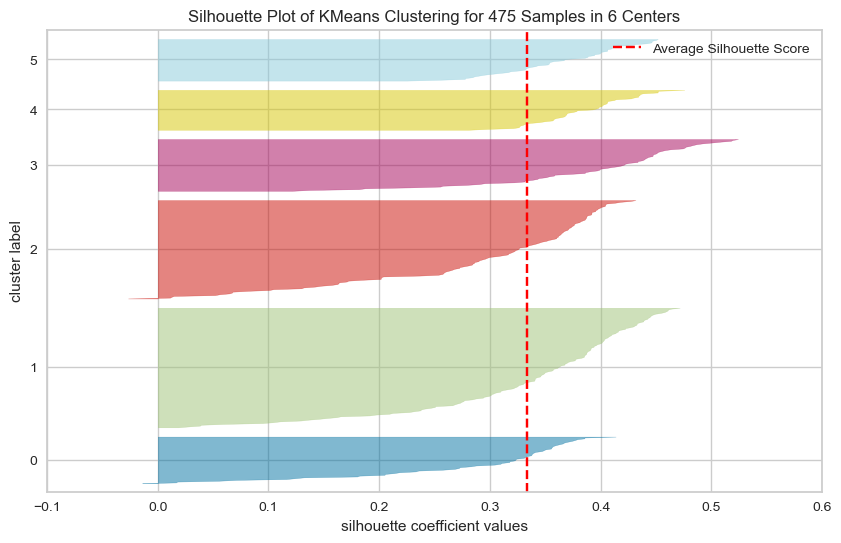

In [83]:
model = KMeans(n_clusters=6, random_state=108)
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
visualizer.fit(X)
visualizer.show(outpath='silhouette kmeans.png')

In [84]:
# set up grid for DBSCAN

epsilon = np.linspace(0.01, 3, num=10)
min_samples = np.arange(2, 10, step=2)
combinations = list(product(epsilon, min_samples))

In [85]:
# DBSCAN grid search function

def db_grid(combinations, X):
    scores = []
    all_label = []
    
    for i, (eps, num_samples) in enumerate(combinations):
        dbscan_model = DBSCAN(eps=eps, min_samples=num_samples).fit(X)
        labels = dbscan_model.labels_
        labels_set = set(labels)
        num_clusters = len(labels_set)
        if -1 in labels_set:
            num_clusters -= 1
        if (num_clusters < 2) or (num_clusters > 25):
            scores.append(-20)
            all_label.append('Poor')
            print('at iteration:', i, 'ep=', eps, 'min_sample=', num_samples, 'number of clusters=',
                  num_clusters, 'moving on...')
            continue
        scores.append(silhouette_score(X, labels))
        all_label.append(labels)
        print('at iteration:', i, 'score:', scores[-1], 'number of clusters:', num_clusters)
    best_index = np.argmax(scores)
    best_parameters = combinations[best_index]
    best_labels = all_label[best_index]
    best_score = scores[best_index]
    
    return {'best_epsilon': best_parameters[0],
            'best_min_samples': best_parameters[1], 
            'best_labels': best_labels,
            'best_score': best_score}
  

In [86]:
db_grid(combinations, X)

at iteration: 0 ep= 0.01 min_sample= 2 number of clusters= 0 moving on...
at iteration: 1 ep= 0.01 min_sample= 4 number of clusters= 0 moving on...
at iteration: 2 ep= 0.01 min_sample= 6 number of clusters= 0 moving on...
at iteration: 3 ep= 0.01 min_sample= 8 number of clusters= 0 moving on...
at iteration: 4 ep= 0.34222222222222226 min_sample= 2 number of clusters= 41 moving on...
at iteration: 5 score: -0.13807542993221752 number of clusters: 11
at iteration: 6 score: -0.10944065413637023 number of clusters: 6
at iteration: 7 score: -0.1977281465192884 number of clusters: 5
at iteration: 8 score: 0.21700762019173225 number of clusters: 4
at iteration: 9 score: 0.21205318032045067 number of clusters: 4
at iteration: 10 score: 0.20874376646761428 number of clusters: 4
at iteration: 11 score: 0.20696224669926527 number of clusters: 4
at iteration: 12 score: 0.10976470050205393 number of clusters: 3
at iteration: 13 score: 0.10976470050205393 number of clusters: 3
at iteration: 14 score

{'best_epsilon': 0.6744444444444445,
 'best_min_samples': 2,
 'best_labels': array([ 0,  0,  1,  0,  0,  0,  0,  2,  0,  0,  1,  1,  0,  0,  0,  1,  1,
         1,  0,  3,  2, -1,  1,  3,  2,  3,  0,  2,  3,  1,  0,  1,  3,  2,
         0,  3,  3,  0,  0,  1,  3,  3,  0,  2,  3,  2,  3,  3,  0,  0,  1,
         1,  0,  3,  1,  0,  1,  0,  2,  2,  2,  3,  0,  1,  3,  0,  2,  1,
         3,  1,  1,  1,  0,  0,  1,  0,  0,  1,  3,  0,  0,  3,  0,  3,  1,
         1,  1,  1,  3,  3,  0,  1,  1,  2,  1,  3,  2,  3,  2,  3,  3,  3,
         0,  3,  3,  3,  1,  3,  3,  3,  3,  3,  1,  2,  3,  3,  3,  2,  3,
         2,  2,  2,  0,  3,  2,  3,  3,  3,  3,  2,  3,  1,  3,  3,  3,  3,
         3,  1,  3,  3,  2,  3,  3,  2,  3,  3,  3,  3,  3,  3,  3,  3,  2,
        -1,  2,  3,  3,  3,  3,  3,  3,  3,  1,  0,  3,  3,  2,  1,  0,  1,
         3,  3,  3,  3,  2,  3,  3,  3,  3,  3,  3,  3,  2,  3,  2,  2,  3,
         3,  2,  3,  3,  2,  2,  3,  2,  2,  2,  3,  3,  2,  3,  3,  3,  2,
         2, 

In [87]:
dbscan = DBSCAN(eps=0.674, min_samples=2)
dbscan.fit(X)
df['cluster dbscan'] = dbscan.labels_

In [88]:
pkl.dump(dbscan, open('dbscan.pkl', 'wb'))

In [89]:
dbscan = pkl.load(open('dbscan.pkl', 'rb'))

In [90]:
# set up grid for Mean Shift

bandwidths = list(np.arange(0.5, 3, step=0.5))
bandwidths

[0.5, 1.0, 1.5, 2.0, 2.5]

In [91]:
# Mean Shift grid search function

def ms_grid(combinations, X):
    scores = []
    all_label = []
    
    for i, bandwidth in enumerate(combinations):
        ms_model = MeanShift(bandwidth=bandwidth).fit(X)
        labels = ms_model.predict(X)
        labels_set = set(labels)
        num_clusters = len(labels_set)
        if -1 in labels_set:
            num_clusters -= 1
        if (num_clusters < 2) or (num_clusters > 25):
            scores.append(-20)
            all_label.append('Poor')
            print('at iteration:', i, 'bandwidth:', bandwidth, 'number of clusters=',
                  num_clusters, 'moving on...')
            continue
        scores.append(silhouette_score(X, labels))
        all_label.append(labels)
        print('at iteration:', i, 'score:', scores[-1], 'number of clusters:', num_clusters)
    best_index = np.argmax(scores)
    best_parameters = combinations[best_index]
    best_labels = all_label[best_index]
    best_score = scores[best_index]
    
    return {'best_bandwidth': best_parameters, 
            'best_labels': best_labels,
            'best_score': best_score}     

In [92]:
ms_grid(bandwidths, X)

at iteration: 0 bandwidth: 0.5 number of clusters= 64 moving on...
at iteration: 1 score: 0.20357162886554211 number of clusters: 7
at iteration: 2 bandwidth: 1.5 number of clusters= 1 moving on...
at iteration: 3 bandwidth: 2.0 number of clusters= 1 moving on...
at iteration: 4 bandwidth: 2.5 number of clusters= 1 moving on...


{'best_bandwidth': 1.0,
 'best_labels': array([4, 4, 3, 4, 4, 4, 4, 2, 4, 4, 3, 3, 4, 4, 4, 3, 3, 3, 4, 3, 2, 5,
        3, 2, 2, 2, 4, 2, 2, 3, 4, 3, 0, 2, 4, 3, 3, 4, 4, 3, 3, 3, 4, 2,
        3, 2, 3, 2, 4, 4, 3, 3, 4, 3, 3, 4, 3, 4, 2, 2, 2, 3, 4, 3, 3, 4,
        2, 3, 3, 3, 3, 3, 4, 4, 3, 4, 4, 3, 0, 4, 4, 3, 4, 3, 3, 3, 3, 3,
        2, 3, 4, 3, 3, 2, 3, 3, 2, 2, 2, 0, 2, 2, 4, 0, 3, 2, 3, 0, 0, 3,
        0, 2, 3, 2, 0, 0, 0, 2, 2, 2, 2, 2, 4, 0, 2, 0, 2, 2, 3, 2, 2, 3,
        2, 3, 0, 2, 2, 3, 0, 3, 2, 0, 2, 2, 2, 3, 0, 0, 0, 2, 0, 0, 1, 3,
        2, 2, 0, 0, 3, 3, 2, 2, 3, 4, 0, 0, 2, 3, 4, 3, 0, 0, 3, 0, 2, 0,
        0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 1, 0, 0, 1, 2, 0, 1, 1, 1, 0,
        0, 1, 0, 0, 0, 2, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 2, 0, 0, 6, 0, 0,
        0, 2, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 2, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 1, 1, 0, 1, 0, 0, 0, 2, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 2, 0, 0,
        1, 0, 0, 0, 1, 0, 2, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 2,

In [93]:
ms = MeanShift(bandwidth=1)
ms.fit(X)
df['cluster ms'] = ms.predict(X)

In [94]:
pkl.dump(ms, open('ms.pkl', 'wb'))

In [95]:
ms = pkl.load(open('ms.pkl', 'rb'))

In [96]:
df.sample(5)

Track  \
443                          Gray Heron III   
10   This Sh*t Right Here (feat. Lil Wayne)   
366     RNB (feat. Lil Wayne & Tate Kobang)   
215                               Butterfly   
36    The Humpty Dance - Album Version Edit   

                                                 Album               Artist  \
443        The Boy and the Heron - Original Soundtrack         Joe Hisaishi   
10                                  Hip Hop 50: Vol. 2          Swizz Beatz   
366                                      Pink Friday 2          Nicki Minaj   
215                                  World Music Radio          Jon Batiste   
36   ...And You Don't Stop - A Celebration of 50 Ye...  Digital Underground   

         Genre  Popularity  Explicit  Duration  Danceability  Energy  Key  \
443  classical          41         0     62000         0.582  0.0727    6   
10     hip hop          29         1    157982         0.564  0.8480    8   
366        pop          61         1    184058         0.657  0.7810    5   
215       jazz          53         0    230440         0.463  0.1740    5   
36     hip hop          11         0    279311         0.829  0.7570   11   

     ...  Mode  Speechiness  Acousticness  Instrumentalness  Liveness  \
443  ...     0       0.0806        0.9790           0.76800    0.0833   
10   ...     1       0.2960        0.0277           0.00000    0.5640   
366  ...     0       0.2800        0.1150           0.00000    0.1010   
215  ...     1       0.0322        0.9740           0.00355    0.0962   
36   ...     1       0.2620        0.0641           0.00000    0.3450   

     Valence    Tempo  cluster kmeans  cluster dbscan  cluster ms  
443    0.324  101.459               4               2           1  
10     0.664   98.508               5               1           3  
366    0.645  179.978               2               0           4  
215    0.122  139.787               0               3           0  
36     0.663  103.570               1               3           3  

[5 rows x 21 columns]

In [97]:
embedding = TSNE(n_components=2, verbose=0).fit_transform(X)

In [98]:
pkl.dump(embedding, open('embedding.pkl', 'wb'))

In [99]:
embedding = pkl.load(open('embedding.pkl', 'rb'))

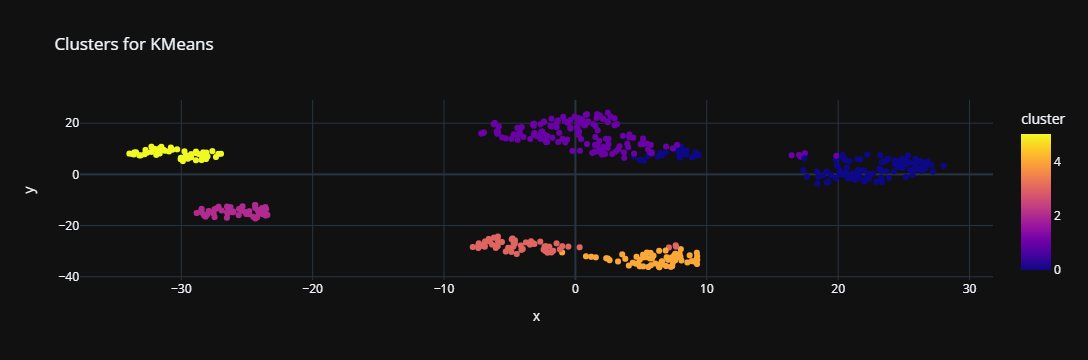

In [102]:
projection_kmeans = pd.DataFrame(data=embedding, columns=['x','y'])
projection_kmeans['Mode'] = df['Mode']
projection_kmeans['cluster'] = df['cluster kmeans']
fig = px.scatter(projection_kmeans, x='x', y='y', color='cluster', template='plotly_dark', hover_data=['x','y','Mode'], 
                 title='Clusters for KMeans')
fig.write_html('projection kmeans.html')
fig.show()

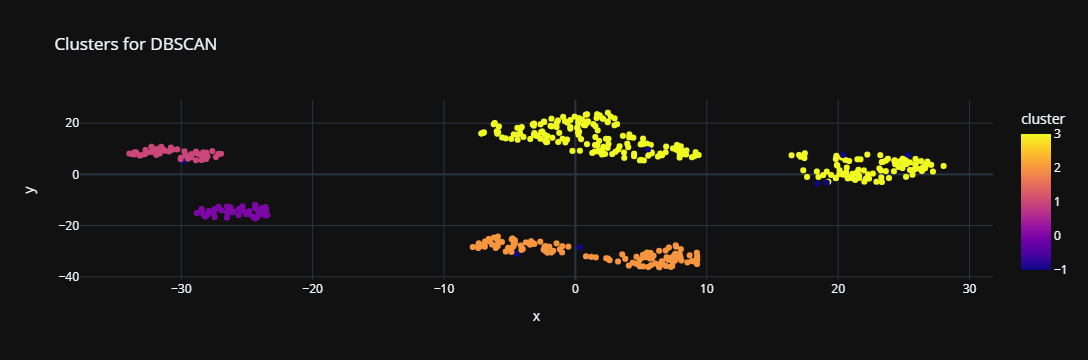

In [104]:
projection_dbscan = pd.DataFrame(data=embedding, columns=['x','y'])
projection_dbscan['Mode'] = df['Mode']
projection_dbscan['cluster'] = df['cluster dbscan']
fig = px.scatter(projection_dbscan, x='x', y='y', color='cluster', template='plotly_dark', hover_data=['x','y','Mode'], 
                 title='Clusters for DBSCAN')
fig.write_html('projection dbscan.html')
fig.show()

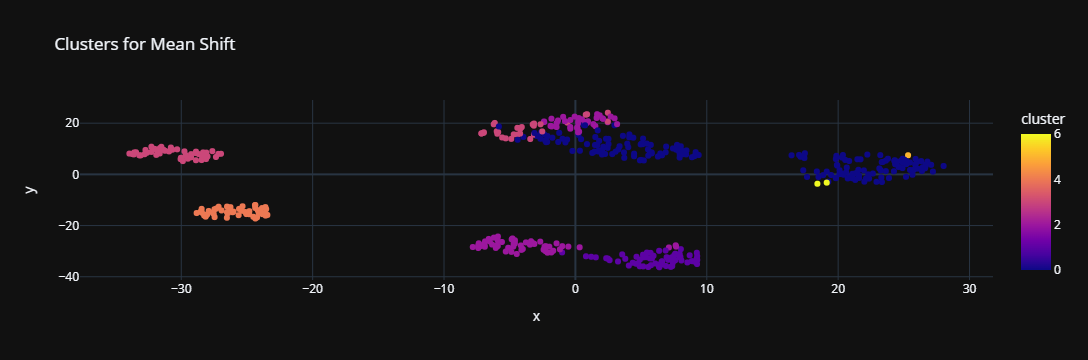

In [106]:
projection_ms = pd.DataFrame(data=embedding, columns=['x','y'])
projection_ms['Mode'] = df['Mode']
projection_ms['cluster'] = df['cluster ms']
fig = px.scatter(projection_ms, x='x', y='y', color='cluster', template='plotly_dark', hover_data=['x','y','Mode'], 
                 title='Clusters for Mean Shift')
fig.write_html('projection ms.html')
fig.show()